In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py
from tqdm import tqdm, trange
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from mpl_toolkits.axes_grid.inset_locator import inset_axes

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    from BEMHelper import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal
from glob import glob 
from pprint import pprint
from mpltools import color

%matplotlib inline
# %config InlineBackend.figure_format='retina'

## Load the data

In [34]:
data = common.load_csv(r"C:\Users\Gerwin\Desktop\Lumped_Impedances_Eps11.csv", header_length=1, footer_length=0)
data2 = common.load_csv(r"C:\Users\Gerwin\Desktop\Lumped_Impedances_Eps10.csv", header_length=1, footer_length=0)

## Impedances

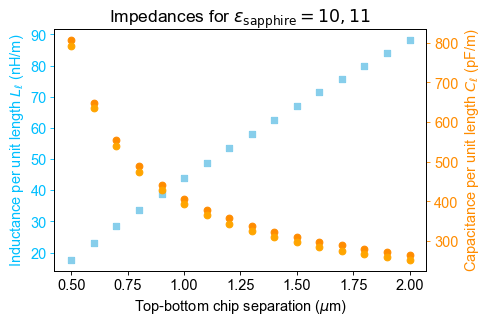

In [35]:
color1 = 'deepskyblue'
color2 = 'darkorange'
color3 = 'skyblue'
color4 = 'orange'

fig = plt.figure(figsize=(6.,4.))
common.configure_axes(13)
ax1, ax2 = common.setup_twinax(color1=color1, color2=color2)
ax1.plot(data[:,0], data[:,1], 's', color=color1)
ax1.plot(data2[:,0], data2[:,1], 's', color=color3)
ax2.plot(data[:,0], data[:, 2], 'o', color=color2)
ax2.plot(data2[:,0], data2[:, 2], 'o', color=color4)
ax1.set_xlabel("Top-bottom chip separation ($\mu$m)")
ax1.set_ylabel(r"Inductance per unit length $L_\ell$ (nH/m)")
ax2.set_ylabel(r"Capacitance per unit length $C_\ell$ (pF/m)")

plt.title(r"Impedances for $\varepsilon_\mathrm{sapphire} = 10, 11$")

# common.save_figure(fig, save_path=r"C:\Users\Gerwin\Desktop")

## Resonance frequency

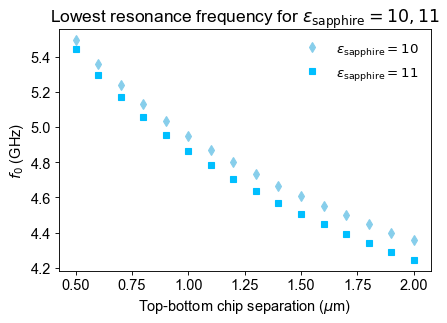

In [21]:
length = 12.161E-3

fig = plt.figure(figsize=(6.,4.))
common.configure_axes(13)
plt.plot(data2[:,0], 1 / (4 * length * np.sqrt(data2[:,1] * data2[:,2] * 1E-12 * 1E-9)) * 1E-9, 
         'd', color=color3, label=r"$\varepsilon_\mathrm{sapphire} = 10$")
plt.plot(data[:,0], 1 / (4 * length * np.sqrt(data[:,1] * data[:,2] * 1E-12 * 1E-9)) * 1E-9, 
         's', color=color1, label=r"$\varepsilon_\mathrm{sapphire} = 11$")
plt.xlabel("Top-bottom chip separation ($\mu$m)")
plt.ylabel(r"$f_0$ (GHz)")
plt.title(r"Lowest resonance frequency for $\varepsilon_\mathrm{sapphire} = 10, 11$")
plt.legend(loc=0, prop={"size" : 12}, frameon=False)

# common.save_figure(fig, save_path=r"C:\Users\Gerwin\Desktop")

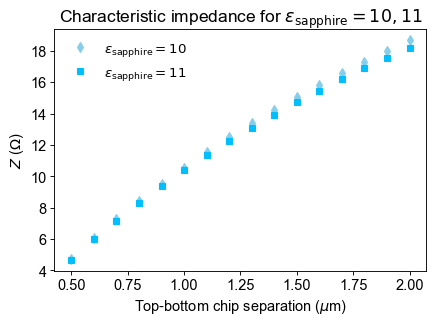

In [37]:
length = 12.161E-3

fig = plt.figure(figsize=(6.,4.))
common.configure_axes(13)
plt.plot(data2[:,0], np.sqrt(data2[:,1] * 1E-9 / (data2[:,2] * 1E-12)), 
         'd', color=color3, label=r"$\varepsilon_\mathrm{sapphire} = 10$")
plt.plot(data[:,0], np.sqrt(data[:,1]  * 1E-9  / (data[:,2] * 1E-12)), 
         's', color=color1, label=r"$\varepsilon_\mathrm{sapphire} = 11$")
plt.xlabel("Top-bottom chip separation ($\mu$m)")
plt.ylabel(r"$Z$ ($\Omega$)")
plt.title(r"Characteristic impedance for $\varepsilon_\mathrm{sapphire} = 10, 11$")
plt.legend(loc=0, prop={"size" : 12}, frameon=False)

# common.save_figure(fig, save_path=r"C:\Users\Gerwin\Desktop")

## Taking into account kinetic inductance

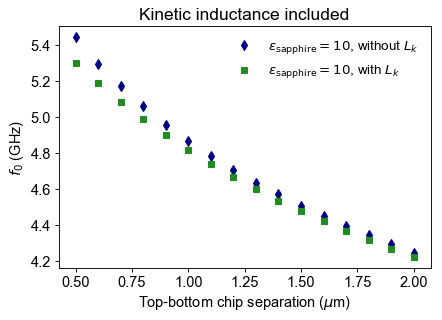

In [95]:
length = 12.161E-3
cross_section = 20E-6 * 0.100E-6
london = 39E-9
mu0 = 4 * np.pi * 1E-7

color1 = 'navy'
color2 = 'forestgreen'

fig = plt.figure(figsize=(6.,4.))
common.configure_axes(13)
plt.plot(data[:,0], 1 / (4 * length * np.sqrt(data[:,1] * 1E-9 * data[:,2] * 1E-12 )) * 1E-9, 
         'd', color=color1, label=r"$\varepsilon_\mathrm{sapphire} = 10$, without $L_k$")
plt.plot(data[:,0], 1 / (4 * length * np.sqrt((data[:,1] * 1E-9 + mu0 * london**2 / cross_section) * data[:,2] * 1E-12 )) * 1E-9, 
         's', color=color2, label=r"$\varepsilon_\mathrm{sapphire} = 10$, with $L_k$")
plt.xlabel("Top-bottom chip separation ($\mu$m)")
plt.ylabel(r"$f_0$ (GHz)")
plt.title(r"Kinetic inductance included")
plt.legend(loc=0, prop={"size" : 12}, frameon=False)

# common.save_figure(fig, save_path=r"C:\Users\Gerwin\Desktop")

## Coupling capacitance

In [96]:
Z0 = 11 
Cin = 2.5E-15
f0 = 4.5E9
omega = 2 * np.pi * f0
qin = omega * Cin * Z0
Qin = np.pi / (2 * qin**2)

In [97]:
print(qin)
print(Qin)

0.0007775441817634739
2598182.9297728036


In [98]:
32.8E-12 * 75E-6

2.4599999999999997e-15

In [99]:
def S21(L, C, Cc, fpts):
    Z0 = np.sqrt(L / C)
    print(Z0)
    omega = 2 * np.pi * fpts
    x = 1j * omega * C + 1 / (1j * omega * L)
    print(1/(2*np.pi) * np.sqrt(1/(L * C)))
    return np.abs(2 / (2 + Z0 * 1j * omega * Cc * x / (x + 1j * omega * Cc)))

In [100]:
idx = common.find_nearest(data[:, 0], 1.0)
cap_l = data[idx, 2]
ind_l = data[idx, 1]

C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


10.381872568
4381646943.81


(-60, 1)

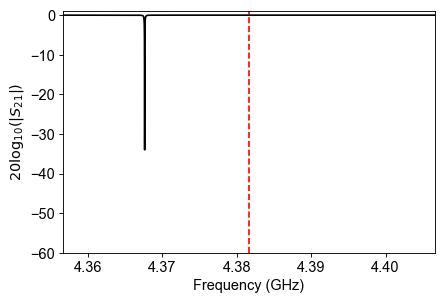

In [148]:
f = np.linspace(3E9, 6E9, 3E5)
L = length/np.sqrt(2) * ind_l * 1E-9
C = length/np.sqrt(2) * cap_l * 1E-12
Cc = 2.25E-14

center = 1 / (2*np.pi * 1E9) * np.sqrt(1/(L * C)) # GHz
span = 0.05 # GHz

plt.plot(f / 1e9, 20 * np.log10 (S21(L, C, Cc, f)), '-k')
plt.xlabel("Frequency (GHz)")
plt.ylabel("$20 \log_{10} (|S_{21}|)$")
# plt.xlim(np.min(f)/1e9, np.max(f)/1e9)
plt.xlim(center - span/2., center + span/2.)
plt.vlines(center, -60, 1, linestyles='--', color='r')
plt.ylim(-60, 1)

In [145]:
y = 20 * np.log10 (S21(L, C, Cc, f))

idx_3dB = common.find_nearest(y, -3)
idx_min = np.argmin(y)

greek_letterz=[chr(code) for code in range(945,970)]
print(greek_letterz[9], "=", np.abs(f[idx_min] - f[idx_3dB]))
print("Q = ", np.abs(f[idx_min] / (2 * (f[idx_min] - f[idx_3dB]))))

10.381872568
4381646943.81
κ = 50000.166667
Q =  43676.1000002


In [149]:
100E-6 * 32E-12

3.2e-15